In [1]:
import oggm.cfg as cfg
from oggm import tasks, graphics, utils, workflow
from oggm.core import flowline
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import scipy
import os
import matplotlib.pyplot as plt
import salem
from scipy.stats.mstats import rankdata
# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
from oggm.core.gis import gaussian_blur
from oggm import global_tasks
from oggm.core import massbalance
from oggm import graphics
import warnings


import shapely.geometry as shpg
from scipy.ndimage import binary_erosion,distance_transform_edt
from oggm.utils import ncDataset

This notebook is a proposal on how to redistribute the glacier ice that has been simulated allong the flowline after a simulation where the glacier has been retreating. Extrapolating the glacier ice onto a map comes with some assumptions and trade-offs. Depending on the purpose one might like to make different choices. e.g. for visualisation, one might like to use a higher resolution, than when using the output to put in for instance a hydrological model. It would offcourse be possible to add different option to the final function, so one can select the option that is best for their needs, however that hasn't been included yet. 

This notebook uses one glacier to show how this redistribution can be done. It has as purpose to discuss it further, before it enters the OGGM code base. 

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
rgi_region = '11'  # Region Central Europe

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = utils.mkdir('/home/anouk/Workspace/OGGM_distributed2', reset=True)

2023-05-03 16:27:38: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-03 16:27:38: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-03 16:27:38: oggm.cfg: Multiprocessing: using all available processors (N=16)


In [3]:
# RGI file
path = utils.get_rgi_region_file(rgi_region)
rgidf = gpd.read_file(path)

# Select a glacier
# rgidf = rgidf.loc[rgidf[rgidf.columns[0]] == 'RGI60-11.01450']
rgidf = rgidf.loc[rgidf[rgidf.columns[0]] == 'RGI60-11.00897']

rgi_ids = ['RGI60-11.01450', 'RGI60-11.00897'] 
# rgi_ids = ['RGI60-03.00841', 'RGI60-03.00840']
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5'

gdirs = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=3, prepro_border=80, reset=True, force=True)

2023-05-03 16:27:39: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2023-05-03 16:27:39: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


### Functions 

In [4]:
# This smooting function is used by the smooth_glacier_topo function to only smooth the topo of the glacier, and excludes 
# the surrounding in the process.

def filter_nan_gaussian_conserving(arr, sigma):
    """Apply a gaussian filter to an array with nans.

    Intensity is only shifted between not-nan pixels and is hence conserved.
    The intensity redistribution with respect to each single point
    is done by the weights of available pixels according
    to a gaussian distribution.
    All nans in arr, stay nans in gauss.
    """
    nan_msk = np.isnan(arr)

    loss = np.zeros(arr.shape)
    loss[nan_msk] = 1
    loss = scipy.ndimage.gaussian_filter(
            loss, sigma=sigma, mode='constant', cval=1)

    gauss = arr.copy()
    gauss[nan_msk] = 0
    gauss = scipy.ndimage.gaussian_filter(
            gauss, sigma=sigma, mode='constant', cval=0)
    gauss[nan_msk] = np.nan

    gauss += loss * arr

    return gauss

In [5]:
def smooth_glacier_topo(gdir, topo_correction=None):

    """This smooting function is used smooth the topo of the glacier, and excludes the surrounding in the process.
    It is therefore different that the smoothing that occurs in the 'process_dem' function, that generates 'topo_smoothed'
    in the gridded_data.nc file. This is of importance when extrapolation to the 2D grid, because the sides on a glacier 
    tongue can other wise be higher that the middle, resulting in an odd shape once the glacier retreats (e.g. with the 
    middle of the tongue retreating faster that the edges). """
    
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
    topo_smooth_glacier = filter_nan_gaussian_conserving(topo_correction.values, 1)

    ds["topo_smoothed_glacier"] = xr.full_like(ds.topo, fill_value=np.nan)
    
    for ki in np.arange(len(ds.x)):
        for kj in np.arange(len(ds.y)):
            ds["topo_smoothed_glacier"].loc[dict(y=ds.y[kj], x=ds.x[ki])] = topo_smooth_glacier[kj, ki]

    topo_smoothed_glacier = xr.where(ds.glacier_mask==1, ds["topo_smoothed_glacier"], ds['topo_smoothed'])

    with ncDataset(gdir.get_filepath('gridded_data'), 'a') as nc:
        vn = 'topo_smoothed_glacier'
        if vn in nc.variables:
            v = nc.variables[vn]
        else:
            v = nc.createVariable(vn, 'f4', ('y', 'x',))
        v.units = 'm'
        v.long_name = 'Glacier topo smoothed'
        v.description = ('DEM smoothed just on the glacier. \
                        (The DEM outside the glacier doesn\'t impact the smoothing.)')
        v[:] = topo_smoothed_glacier


In [6]:
def assign_points_to_section(gdir, filesuffix_diagnostics='', option=1):

    """This function assigns the points on the grid to the different elevation bands along the flowline, creating the 
    variable points_by_section in the gridded data.
    
    Option 1 (default) uses the topo that create with smooth_glacier_topo. This is smoothed over the glacier, 
                without taking into account its surroundings. 
    Option 2 uses the regular smoothed_topo.""" 
    
    
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()

    f = gdir.get_filepath('fl_diagnostics' + filesuffix_diagnostics)

    with xr.open_dataset(f) as di:
        fl_ids = di.flowlines.data

    # For now we pick the last flowline (the main one)
    with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as dg:
        dg = dg.load()
    dg2 = dg[dict(time=0)]

    # number of pixels in section along flowline
    npix1 = dg2.area_m2 / (gdir.grid.dx ** 2)
    npix_rcumsum = np.around(npix1.values[::-1].cumsum()[::-1])
    npix = npix_rcumsum[0:-2] - npix_rcumsum[1:-1]

    if option == 1:
        rank_hl1 = rankdata(ds.where(ds.glacier_mask == 1).topo_smoothed_glacier)
    elif option == 2:
        rank_hl1 = rankdata(ds.where(ds.glacier_mask == 1).topo_smoothed)

    ds['rank_hl1'] = (('y', 'x'), rank_hl1)
    ds['rank_hl1'] = ds.where(ds.glacier_mask == 1).rank_hl1

    ds["fl_att"] = xr.full_like(ds.rank_hl1, fill_value=np.nan)

    for ki in ds.x:
        for kj in ds.y:
            check = ds.sel(y=kj, x=ki).rank_hl1.values
            if not np.isnan(check):
                kn = np.sum(npix_rcumsum >= check)
                ds["fl_att"].loc[dict(y=kj, x=ki)] = kn

    fl_att = ds['fl_att']

    with ncDataset(gdir.get_filepath('gridded_data'), 'a') as nc:
        vn = 'points_by_section'
        if vn in nc.variables:
            v = nc.variables[vn]
        else:
            v = nc.createVariable(vn, 'f4', ('y', 'x',))
        v.units = '-'
        v.long_name = 'points grouped by section along the flowline'
        v.description = ('Points grouped by section along the follow line. Here the lowest number corresponds to the '
                         'lowest elevation band containing glacier ice at the time of initialization.')
        v[:] = fl_att

In [7]:
def assign_points_within_section(gdir, filesuffix_diagnostics='', option=2):
    
    """This function ranks the points within the different elevation bands along the flowline in order they will disappear 
    and stores this information as the variable points_ranked_within_section in gridded_data.
    
    Option 1 ranks by distributed_thickness
    Option 2 (default) ranks based on the thickness combined with elevation, thereby trying to take into mimic the
    mass balance gradient.""" 
    
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
    
    f = gdir.get_filepath('fl_diagnostics' + filesuffix_diagnostics)

    with xr.open_dataset(f) as di:
        fl_ids = di.flowlines.data

    # For now we pick the last flowline (the main one)
    with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as dg:
        dg = dg.load()
    dg2 = dg[dict(time=0)]
    min_alt = ds.topo_smoothed_glacier.min().values
    
    
    npix1 = dg2.area_m2/(gdir.grid.dx**2)
    npix_rcumsum = np.around(npix1.values[::-1].cumsum()[::-1])
    npix = npix_rcumsum[0:-2] - npix_rcumsum[1:-1]
    
    ds["fl_att_sub"] = xr.full_like(ds.points_by_section, fill_value=np.nan)
    ds["rank_hl2"] = xr.full_like(ds.points_by_section, fill_value=0)

    for ki in np.arange(len(npix)):
        ds["rank_hl2_" + str(ki)] = xr.full_like(ds.points_by_section, fill_value=0)
        
        if option==1:
            rank_hl2 = rankdata(ds.distributed_thickness.where(ds.points_by_section==ki))
        elif option==2:
            ds["corrected_thick"] = ((ds.topo_smoothed_glacier - min_alt + 1) * 1.003) * ds.distributed_thickness
            rank_hl2 = rankdata(ds.corrected_thick.where(ds.points_by_section==ki))
        ds["rank_hl2_" + str(ki)] = (('y', 'x'), rank_hl2)
        ds["rank_hl2_" + str(ki)] = ds["rank_hl2_" + str(ki)].where(ds.points_by_section==ki, 0)

    rank_hl3 = ds.rank_hl2_0.values

    for ki in np.arange(1,np.max(ds.points_by_section)):
        rank_hl3 = rank_hl3 + (ds['rank_hl2_' + str(int(ki))]).values

    ds["rank_hl3"] = xr.full_like(ds.points_by_section, fill_value=np.nan)
    ds["rank_hl3"] = (('y', 'x'), rank_hl3)
    ds['fl_att_sub']=ds.where(ds.glacier_mask==1).rank_hl3

    fl_att_sub = ds['fl_att_sub']

    with ncDataset(gdir.get_filepath('gridded_data'), 'a') as nc:
        vn = 'points_ranked_within_section'
        if vn in nc.variables:
            v = nc.variables[vn]
        else:
            v = nc.createVariable(vn, 'f4', ('y', 'x',))
        v.units = '-'
        v.long_name = 'points ranked within each section along the flowline'
        v.description = ('...')
        v[:] = fl_att_sub
    

In [8]:
def redistribute_thicknesses(gdir, ys=0, ye=10, filesuffix_diagnostics='', smooth_radius=None):

    """This function redistributes the simulated glacier area and volume allong the elevation band flowline back onto
    a 2D grid. In order for this to work, the glacier can not advance beyond its initial state, the glacier diagnostics
    during the simulation have to be stored, the gridded_data file needs to contain both the points_by_section and 
    points_ranked_within_section variables.
    
    ys:  the first year to be redistributed
    ye:  the last year to be redistributed """
    
    f = gdir.get_filepath('fl_diagnostics' + filesuffix_diagnostics)
    with xr.open_dataset(f) as di:
        fl_ids = di.flowlines.data

    # For now we pick the last flowline (the main one)
    with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as dg:
        dg = dg.load()

    dg2 = dg[dict(time=0)]

    # number of pixels in section along flowline
    npix1 = dg2.area_m2 / (gdir.grid.dx ** 2)
    npix_rcumsum = np.around(npix1.values[::-1].cumsum()[::-1])
    npix = npix_rcumsum[0:-2] - npix_rcumsum[1:-1]
    
    for yr in np.arange(ys, ye, 1):
        redistribute_thickness(gdir, yr=yr, dg=dg.sel(dict(time=yr)), npix=npix, smooth_radius=smooth_radius)
            
def redistribute_thickness(gdir, yr=0, dg=None, npix=None, smooth_radius=None, min_thick=1):

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()           
    ds['thickness_' + str(yr)] = xr.full_like(ds.points_by_section, fill_value=np.nan)
    if smooth_radius != 0:
        ds['thickness_' + str(yr) + "_smooth"] = xr.full_like(ds.points_by_section, fill_value=np.nan)
    
    residual_area = 0
    residual_pix = 0

    Area2 = 0
    for ki in np.arange(len(npix),-1,-1):
        if dg.area_m2[ki].values != 0:            
            pix_cov = ((dg.area_m2[ki].values)/(gdir.grid.dx**2)) + residual_pix
            mask = ((ds.points_by_section==(ki+1)) & (ds.points_ranked_within_section>= (npix[ki]-pix_cov)))
            residual_pix = pix_cov - mask.sum().sum().values
            vol_sim = dg.volume_m3[ki].values
            vol_dis = xr.where(mask, ds.distributed_thickness, 0).sum().sum() * (gdir.grid.dx**2)
            area = mask.sum().sum() * (gdir.grid.dx**2)
            vol_cor = (vol_dis - vol_sim)/ area
            Area2 = Area2 + area.values   
            ds["thickness_" + str(yr)] = xr.where(mask,  ds.distributed_thickness - vol_cor, ds["thickness_" + str(yr)]) 
           
    # here I added a final smoothing of the total thickness distribution (copied from distribute_thickness_per_altitude)
    thick = ds["thickness_" + str(yr)]
    
    # Make sure all glacier covered cells have the miniumum thickness
    thick = xr.where(thick<=min_thick, min_thick, thick)
    # set all nans to 0 for smoothing
    thick = xr.where(np.isnan(thick), 0, thick)
    glacier_mask = thick > 0
    init_vol = dg.volume_m3.sum().values
    # Smooth
    dx = gdir.grid.dx
    if smooth_radius != 0:
        if smooth_radius is None:
            smooth_radius = np.rint(cfg.PARAMS['smooth_window'] / dx)
        thick = gaussian_blur(thick, int(smooth_radius))
        thick = np.where(glacier_mask, thick, min_thick)

        # Re-mask
        utils.clip_min(thick, min_thick, out=thick)
        thick[glacier_mask == 0] = np.NaN
        assert np.all(np.isfinite(thick[glacier_mask == 1]))

        # Conserve volume
        tmp_vol = np.nansum(thick * dx**2)
        thick *= init_vol / tmp_vol

        ds["thickness_" + str(yr)] = xr.where(glacier_mask, thick, np.nan)
    
    conservation = ((ds["thickness_" + str(yr)].sum().sum() * (gdir.grid.dx**2)) / dg.volume_m3.sum()) * 100
    print("volume conservation: " + str(float(conservation)) + ' %')
    area_conservation = (((ds["thickness_" + str(yr)] > 0).sum() * (gdir.grid.dx**2)) / dg.area_m2.sum()) * 100
    print(f"area conservation: {float(area_conservation.values)} %")
    
    thickness = ds["thickness_" + str(yr)]
    #ds.close()

    with ncDataset(gdir.get_filepath('gridded_data'), 'a') as nc:
        vn = "thickness_" + str(yr)
        if vn in nc.variables:
            v = nc.variables[vn]
        else:
            v = nc.createVariable(vn, 'f4', ('y', 'x',))
        v.units = '-'
        v.long_name = '...'
        v.description = ('...')
        v[:] = thickness


### Start experiment - to redistribute the ice after the simulation

In [9]:
gdir = gdirs[0]
### Do a random run
tasks.run_constant_climate(gdir, nyears=100, y0=2000, temperature_bias=0.25, store_fl_diagnostics=True);

In [10]:
# Create an array with only the topo on the glacier and substract X meter from the elevation of glaciers on the outline. 
# This value is arbritary, but seems to result in a more realistic retreat of the glacier tongue than 
# that without this correction. A physical explanation for this might be that there is an influence of steep valley walls 
# along the tongue on the glacier DEM, causing the sides of the glacier to be higher than the center. 
border_correction = 40 
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
topo_correction = xr.where(ds.glacier_mask==1, ds.topo, np.nan) - (xr.where(ds.glacier_mask==1, ds.glacier_ext, np.nan) * border_correction)

smooth_glacier_topo(gdir, topo_correction=topo_correction)

In [11]:
tasks.distribute_thickness_per_altitude(gdir, topo='topo_smoothed_glacier');

In [12]:
assign_points_to_section(gdir, filesuffix_diagnostics='', option=1)

In [13]:
assign_points_within_section(gdir, filesuffix_diagnostics='', option=2)

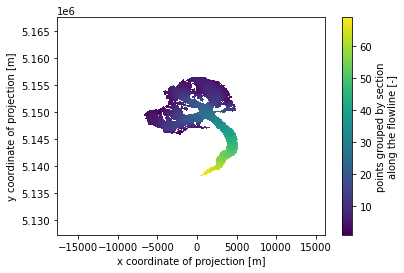

In [14]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds.points_by_section.plot()

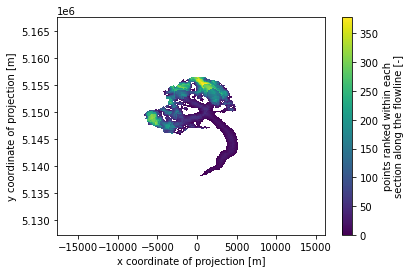

In [15]:
ds.points_ranked_within_section.plot()

In [16]:
redistribute_thicknesses(gdir, ys=0, ye=100, filesuffix_diagnostics='', smooth_radius=None)

volume conservation: 100.0 %
area conservation: 99.97986886601952 %
volume conservation: 99.99999999999999 %
area conservation: 99.98521256062833 %
volume conservation: 100.00000000000003 %
area conservation: 99.98722848060734 %
volume conservation: 99.99999999999999 %
area conservation: 99.99149741838357 %
volume conservation: 99.99999999999997 %
area conservation: 99.99972494403522 %
volume conservation: 100.00000000000003 %
area conservation: 99.99775987850556 %
volume conservation: 100.0 %
area conservation: 99.99365558246271 %
volume conservation: 100.0 %
area conservation: 99.99551534136326 %
volume conservation: 100.0 %
area conservation: 99.9805656782379 %
volume conservation: 100.0 %
area conservation: 99.9948157576679 %
volume conservation: 99.99999999999997 %
area conservation: 99.99240181204955 %
volume conservation: 99.99999999999997 %
area conservation: 99.99632986808467 %
volume conservation: 100.0 %
area conservation: 99.98358524519955 %
volume conservation: 100.0000000

In [17]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

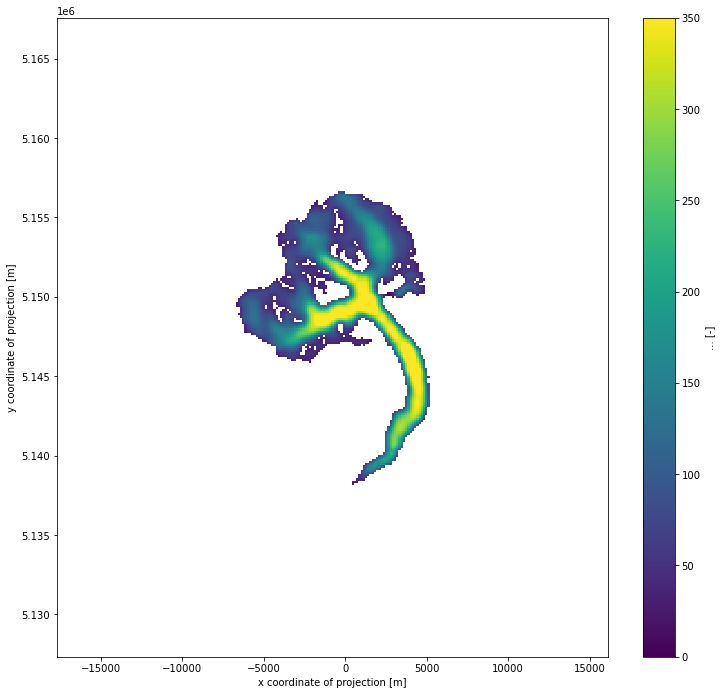

In [18]:
from matplotlib import animation

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(gdir.grid.nx/20,gdir.grid.ny/25))

# Plot the initial frame. 
cax = ds.thickness_0.plot(
    add_colorbar=True,
    cmap='viridis',
    vmin=0, vmax=350,
    cbar_kwargs={
        'extend':'neither'
    }
)

def animate(frame):
    cax.set_array(ds['thickness_' + str(int(frame))].values.flatten())

ani = animation.FuncAnimation(
    fig,            
    animate,        
    frames=99,      
    interval=200,     
    save_count=1500
)

In [19]:
HTML(ani.to_jshtml())